# Analyze the sensitivity of different neural responses to perturbations to different parts of song

In [1]:
%matplotlib inline
import editdistance
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from aux import zscore, get_seg
from disp import set_plot, plot_b, get_line

cc = np.concatenate

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

NR = 224  # original number of responses
NTR = 276  # number of trials

In [2]:
DF_MA_PARAM = pd.read_csv('data/simple/neur/baker_ma_fit_param.csv')

tau_rs = np.array(DF_MA_PARAM['TAU_R'])
tau_as = np.array(DF_MA_PARAM['TAU_A'])
x_ss = np.array(DF_MA_PARAM['X_S'])
x_ps = np.array(DF_MA_PARAM['X_P'])

DF_MA_PARAM

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [3]:
def smlt_ma_(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [4]:
# step sine and step pulse
t_step = np.arange(0, 20, DT)
i_step = (t_step < 10).astype(float)
i_0 = np.zeros(len(t_step))

     EXPT_ID     LINE  FLY   ROI  ROI_USED   FIT_ERR  SUCCESS  T_0       R_0  \
206      206  SS47261    2  ring      True  0.250282     True -0.0 -0.027493   

        TAU_R     TAU_A      X_S        X_P  
206  1.321935  1.321053  0.77631  17.895161  


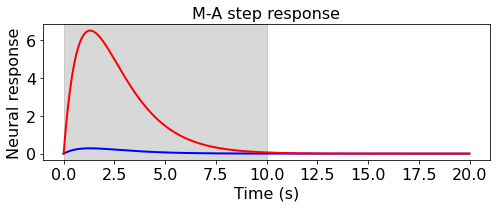

In [5]:
expt_id = 206
print(DF_MA_PARAM[DF_MA_PARAM.EXPT_ID == expt_id])

tau_r = tau_rs[expt_id]
tau_a = tau_as[expt_id]
x_s = x_ss[expt_id]
x_p = x_ps[expt_id]

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
ax.plot(t_step, smlt_ma_(i_step, i_0, tau_r, tau_a, x_s, x_p), c='b', lw=2)
ax.plot(t_step, smlt_ma_(i_0, i_step, tau_r, tau_a, x_s, x_p), c='r', lw=2)

set_plot(ax, x_label='Time (s)', y_label='Neural response', title='M-A step response', font_size=16)
ax.axvspan(0, 10, color='gray', alpha=.3)

In [6]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Natural song snippets

In [7]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [8]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [9]:
from aux import get_seg
# get snippets
nt = int(round(10*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sng_s = np.zeros(len(t))
sng_s[t < 10] = 1
sng_p = np.zeros(len(t))
sng_p[t < 10] = 2

sngs = [sng_s, sng_p]  # song snippets


for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs.extend(segs)
    
sngs = np.array(sngs)[:400]

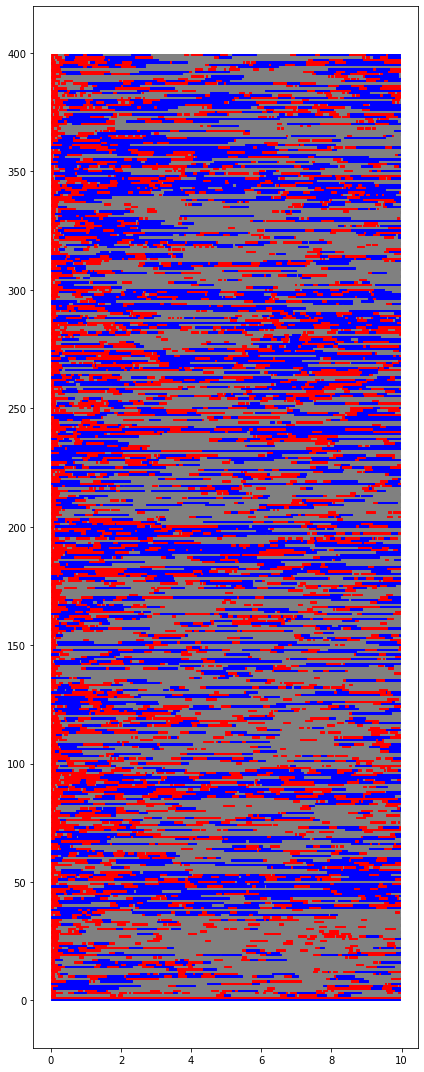

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

In [11]:
from aux import get_seg

In [12]:
# define song perturbation functions
import editdistance
def sng_edit_dist(sng_0, sng_1):
    sng_str_0 = ''.join([str(sng_) for sng_ in sng_0])
    sng_str_1 = ''.join([str(sng_) for sng_ in sng_1])
    return editdistance.eval(sng_str_0, sng_str_1)

def sng_seg(sng):
    bds_q = get_seg(sng==0, min_gap=1)[1]
    bds_s = get_seg(sng==1, min_gap=1)[1]
    bds_p = get_seg(sng==2, min_gap=1)[1]

    bds = cc([bds_q, bds_s, bds_p])
    modes = cc([np.repeat(0, len(bds_q)), np.repeat(1, len(bds_s)), np.repeat(2, len(bds_p))])
    
    idx_sorted = np.argsort(bds[:, 0])
    return bds[idx_sorted, :], modes[idx_sorted]


def warp(sng, nedit, max_iter=None):
    """Time-warp the segments of a song snippet."""
    sng_warped = sng.copy()
    
    dedit = 0
    if max_iter is None:
        max_iter = 20*nedit
    
    for cedit in range(max_iter):
        
        # break song into segments
        bds, modes = sng_seg(sng_warped)
        nseg = len(bds)
        
        # warp song by one unit
        sng_cnd = sng_warped.copy()
        
        ## pick rand segment
        iseg = np.random.randint(0, nseg)
        
        ## pick rand operation
        iop = np.random.randint(4)  # 0: prepend, 1: append, 2: shorten beginning, 3: shorten end
        
        if (iop == 0) and (bds[iseg][0] > 0):  # prepend
            sng_cnd[bds[iseg][0]-1] = modes[iseg]
            
        elif (iop == 1) and (bds[iseg][1] < len(sng)):  # append
            sng_cnd[bds[iseg][1]] = modes[iseg]
            
        elif (iop == 2) and (bds[iseg][0] > 0):  # shorten beginning
            sng_cnd[bds[iseg][0]] = modes[iseg-1]
            
        elif (iop == 3) and (bds[iseg][1] < len(sng)):  # shorten end
            sng_cnd[bds[iseg][1]-2] = modes[iseg+1]
                
        # run check to see if segment number preserved and edit distance incremented
        if (len(sng_seg(sng_cnd)[0]) != nseg) or (sng_edit_dist(sng_cnd, sng) != (dedit+1)):
            continue
            
        dedit += 1
        sng_warped = sng_cnd.copy()
        
        if dedit == nedit:
            break
        
    else:
        raise Exception('Max number of edit attempts reached in warp function.')
        
    return sng_warped


def flicker(sng, nedit, max_iter=None):
    """Change song modes at random timepoints."""
    sng_flickered = sng.copy()
    
    dedit = 0
    if max_iter is None:
        max_iter = 20*nedit
        
    for cedit in range(max_iter):
        sng_cnd = sng_flickered.copy()
        
        # choose random timepoint
        it = np.random.randint(len(sng))
        
        mode = sng_flickered[it]
        if mode == 0:  # quiet
            if np.random.randn() < 0:
                sng_cnd[it] = 1  # change to sine
            else:
                sng_cnd[it] = 2  # change to pulse 
        elif mode == 1:  # sine 
            if np.random.randn() < 0:
                sng_cnd[it] = 0  # change to quiet 
            else:
                sng_cnd[it] = 2  # change to pulse 
        elif mode == 2:  # pulse
            if np.random.randn() < 0:
                sng_cnd[it] = 0  # change to quiet 
            else:
                sng_cnd[it] = 1  # change to sine 
                
        # check edit distance incremented
        if sng_edit_dist(sng_cnd, sng) != dedit+1:
            continue
            
        dedit += 1
        sng_flickered = sng_cnd.copy()
        
        if dedit == nedit:
            break
            
    else:
        raise Exception('Max number of edit attempts reached in flicker function.')
        
    return sng_flickered

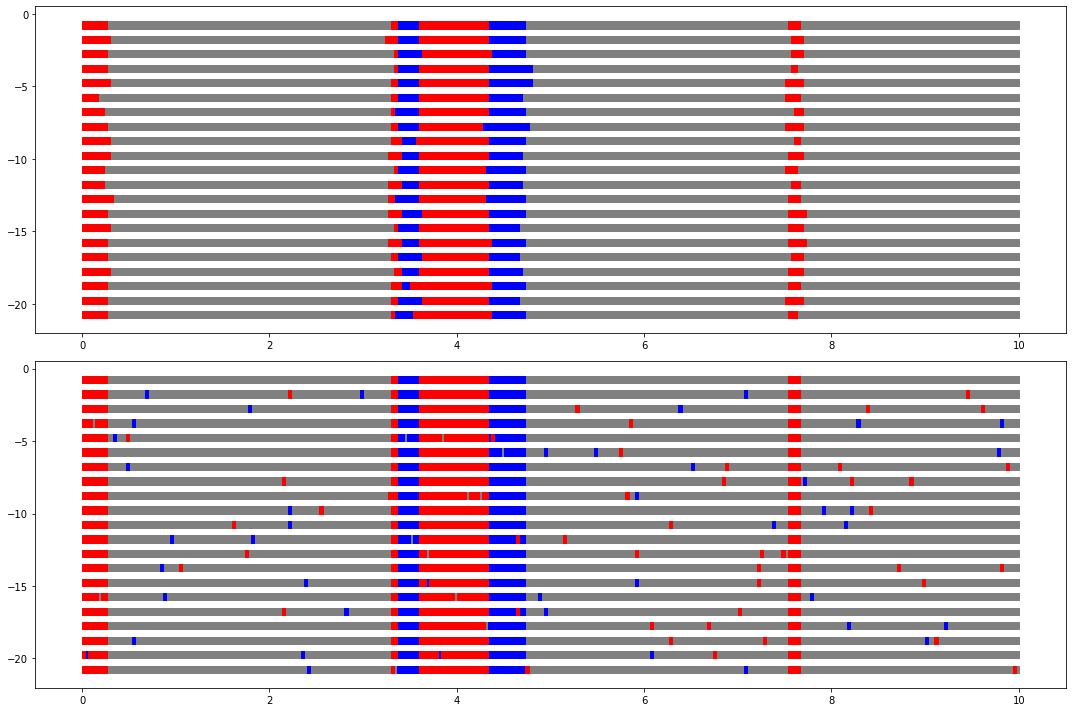

In [88]:
# pick a nice example song
isng = 13
sng_base = sngs[isng]
nedit = 5
nperturb = 20

fig, axs = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)

for ax in axs:
    plot_b(ax, t, sng_base, [0, 10, -1, -.5], c=['gray', 'b', 'r'])
    
for cwarp in range(1, nperturb+1):
    plot_b(axs[0], t, warp(sng_base, nedit), [0, 10, -cwarp-1, -cwarp-.5], c=['gray', 'b', 'r'])
    
for cflicker in range(1, nperturb+1):
    plot_b(axs[1], t, flicker(sng_base, nedit), [0, 10, -cflicker-1, -cflicker-.5], c=['gray', 'b', 'r'])

In [89]:
tau_r = 2
tau_a = 1.3
x_s = 5
x_p = 10

isng = 10
sng_base = sngs[isng]
nedit = 5
nperturb = 200

i_s_base = (sng_base == 1).astype(float)
i_p_base = (sng_base == 2).astype(float)

r_base = smlt_ma_(i_s_base, i_p_base, tau_r, tau_a, x_s, x_p)

sngs_warped = [warp(sng_base, nedit) for _ in range(nperturb)]
sngs_flickered = [flicker(sng_base, nedit) for _ in range(nperturb)]

In [90]:
rs_warped = []
ds_warped = []

for sng in sngs_warped:
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r_warped = smlt_ma_(i_s, i_p, tau_r, tau_a, x_s, x_p)
    rs_warped.append(r_warped)
    ds_warped.append(np.linalg.norm(r_warped - r_base))
    
rs_flickered = []
ds_flickered = []

for sng in sngs_flickered:
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r_flickered = smlt_ma_(i_s, i_p, tau_r, tau_a, x_s, x_p)
    rs_flickered.append(r_flickered)
    ds_flickered.append(np.linalg.norm(r_flickered - r_base))

(array([ 9., 31., 42., 46., 44., 18.,  6.,  2.,  1.,  1.]),
 array([0.26421833, 0.49204985, 0.71988138, 0.9477129 , 1.17554442,
        1.40337594, 1.63120747, 1.85903899, 2.08687051, 2.31470204,
        2.54253356]),
 <BarContainer object of 10 artists>)

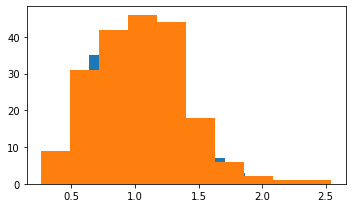

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
ax.hist(ds_warped)
ax.hist(ds_flickered)

In [93]:
print(np.mean(ds_warped))
print(np.mean(ds_flickered))

1.0202599200792815
1.0461609780895353


In [84]:
tau_r, tau_a, x_s, x_p

(2, 1.3, 1, 10)

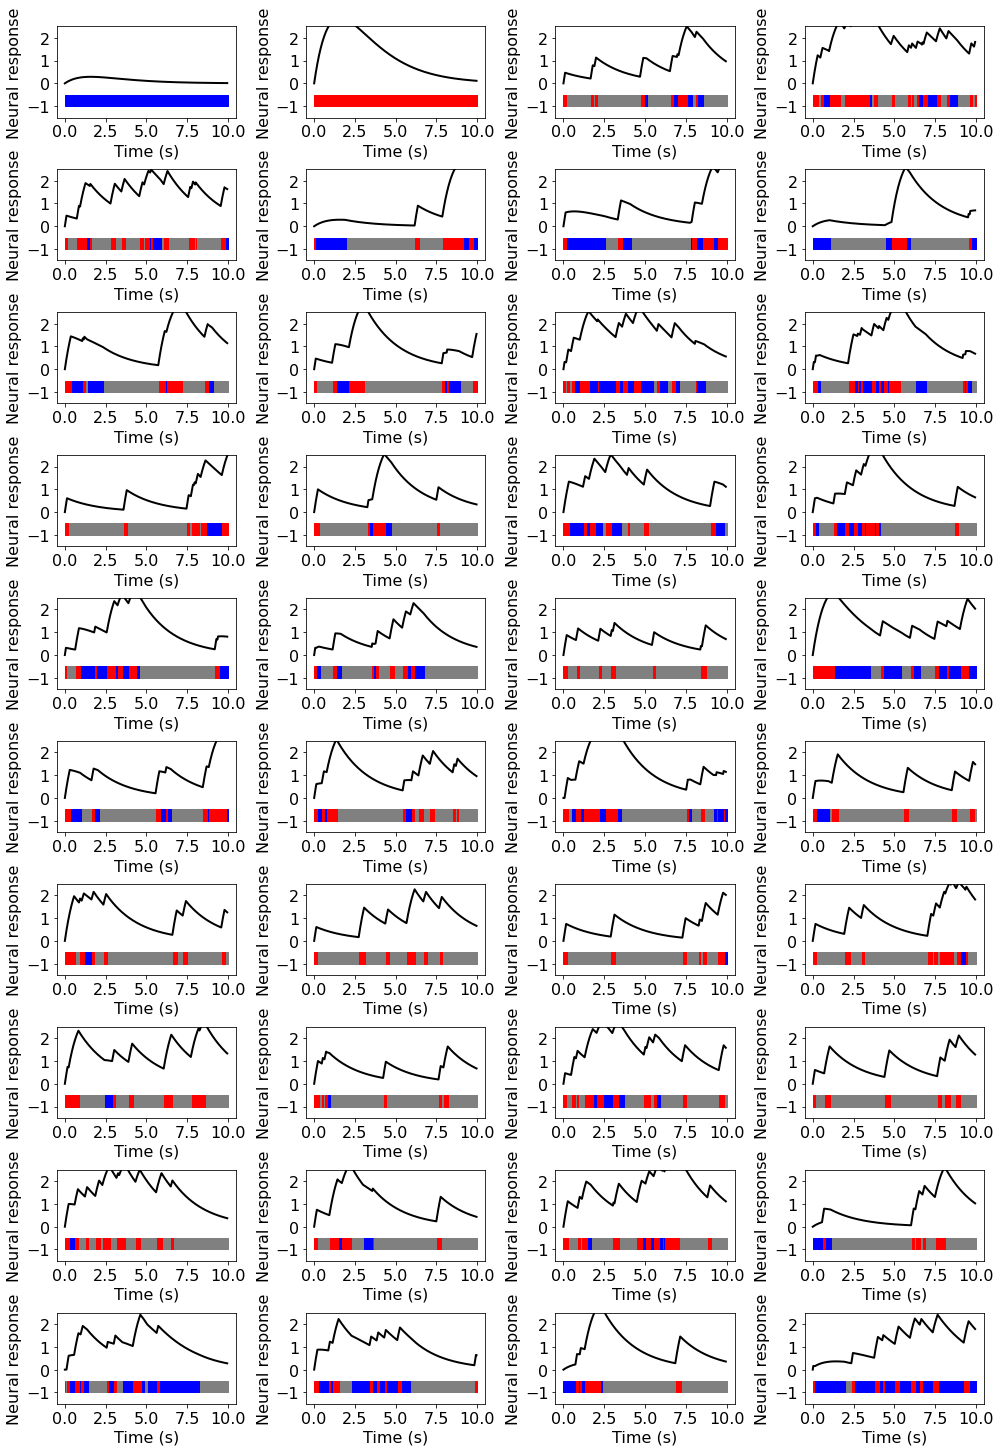

In [87]:
nxpl = 40
fig, axs = plt.subplots(nxpl//4, 4, figsize=(14, nxpl/2), tight_layout=True)
for sng, ax in zip(sngs, axs.flatten()):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r_ma = smlt_ma_(i_s, i_p, tau_r, tau_a, x_s, x_p)
    
    ax.plot(t, r_ma, c='k', lw=2)
    
    plot_b(ax, t, sng, [0, 10, -1, -.5], c=['gray', 'b', 'r'])
    
    ax.set_xlabel('Time (s)')
    
    set_plot(ax, y_lim=(-1.5, 2.5), x_label='Time (s)', y_label='Neural response', font_size=16)